# Analysis of performance on the BioCreative V evaluation dataset

Tong Shu Li<br>
Created on: 2015-10-06<br>
Last updated: 2015-12-07

Now that the gold standard for the final evaluation dataset has been released, we can perform a more detailed analysis of our results and see where we went wrong.

In [1]:
from collections import defaultdict
from itertools import groupby
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys

In [2]:
%matplotlib inline

In [3]:
sys.path.append("..")

In [4]:
from src.lingpipe.file_util import read_file
from src.lingpipe.file_util import save_file

from src.eval_perf import performance
from src.eval_perf import official_F_score

from src.data_model import *
from src.F_score import F_score
from src.mesh_filter import filter_relations

---

### First we need to de-anonymize the paper identifiers

In [5]:
def read_orig_ids(fname):
    title = dict()
    for line in read_file(fname):
        vals = line.split("|")
        if len(vals) == 3 and vals[1] == "t":
            title[vals[2]] = int(vals[0])
            
    return title

In [6]:
fname = os.path.abspath(os.path.join("..", "data", "final_eval", "orig_data", "CDR_TestSet.txt"))
masked_titles = read_orig_ids(fname)

fname = os.path.abspath(os.path.join("..", "data", "gold_standard", "CDR_TestSet.txt"))
real_titles = read_orig_ids(fname)

In [7]:
assert masked_titles.keys() == real_titles.keys()

In [8]:
paper_mapping = {masked_titles[title] : real_titles[title] for title in real_titles.keys()}
save_file("testset_mapping.pickle", paper_mapping)

---

### Read the gold standard

In [9]:
def read_gold_standard(dataset, file_format = "list"):
    assert dataset in ["training", "development", "test"]
    assert file_format in ["list", "dict"]
    
    fname = "parsed_{0}_set_{1}.pickle".format(dataset, file_format)
    
    save_loc = os.path.abspath(os.path.join("..", "data", "gold_standard", fname))
    
    fname = "CDR_{0}Set.txt".format(dataset.capitalize())
    loc = os.path.abspath(os.path.join("..", "data", "gold_standard"))
    
    return parse_file(save_loc, loc = loc, fname = fname,
        is_gold = True, return_format = file_format, fix_acronyms = False)

In [10]:
eval_gold = read_gold_standard("test", file_format = "dict")

### Read the original NER output

In [11]:
save_loc = loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "crowd_testset.pickle"))
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "crowd_all_relations.txt"))
testset = parse_file(save_loc, loc = loc, fname = "CDR_TestSet.txt",
                    is_gold = False, return_format = "dict", fix_acronyms = False)

In [12]:
def remap(papers):
    res = dict()
    for uid, paper in papers.items():
        paper.pmid = paper_mapping[uid]
        res[paper_mapping[uid]] = paper
        
    return res

In [13]:
if 0 in set(testset.keys()):
    testset = remap(testset)
    save_file(save_loc, testset)

---

### Read the crowd results

In [14]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "abstract_relation_res.tsv"))

abs_res = pd.read_csv(loc, sep = '\t')
abs_res = abs_res.rename(columns = {"percent_agree": "norm_conf_score"})

In [15]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "sentence_relation_abs_res.tsv"))
sent_res = pd.read_csv(loc, sep = '\t')

sent_res = sent_res.rename(columns = {"conf_score": "norm_conf_score",
                                      "score_vote_max": "num_votes"})

In [16]:
abs_res.loc[:, "pmid"] = abs_res.loc[:, "pmid"].map(lambda val: paper_mapping[val])

In [17]:
sent_res.loc[:, "pmid"] = sent_res.loc[:, "pmid"].map(lambda val: paper_mapping[val])

In [18]:
abs_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,norm_conf_score,pmid,unit_id,chemical_id,disease_id
0,bcv_final_eval_hard_0,yes_direct,0.8182,1,0.198438,8701013,773935948,MESH:D006632,MESH:D003693
1,bcv_final_eval_hard_1,yes_direct,0.0000,0,0.000000,439781,773935949,MESH:D000809,MESH:D007022
2,bcv_final_eval_hard_10,yes_direct,0.0000,0,0.000000,23666265,773935958,MESH:D013498,MESH:D003556
3,bcv_final_eval_hard_100,yes_direct,0.0000,0,0.000000,24114426,773936048,MESH:D000431,MESH:D012893
4,bcv_final_eval_hard_1000,yes_direct,0.0000,0,0.000000,3155884,773936948,MESH:D004837,MESH:D009202


In [19]:
sent_res.head()

,chemical_id,norm_conf_score,disease_id,pmid,num_votes,sentence_ids,uniq_ids,unit_ids
0,MESH:D006632,0.000000,MESH:D014456,8701013,0,0_1,bcv_final_eval_easy_1,773931696
1,MESH:D015738,1.000000,MESH:D003693,8701013,5,0_0|0_2|0_3,bcv_final_eval_easy_0|bcv_final_eval_easy_3|bc...,773931695|773931698|773931699
2,MESH:D015738,0.000000,MESH:D014456,8701013,0,0_1,bcv_final_eval_easy_2,773931697
3,MESH:D012964,0.189597,MESH:D007022,439781,1,1_0,bcv_final_eval_easy_5,773931700
4,MESH:D000305,0.802824,MESH:D007674,22836123,4,2_4,bcv_final_eval_easy_10,773931705


In [20]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "cid_relations.pickle"))
cid_rels = save_file(loc)

cid_rels = {paper_mapping[pmid] : rels for pmid, rels in cid_rels.items()}

## Combine all results together

In [21]:
def flat_repr(id_set):
    vals = ["{0}:{1}".format(v.uid_type, v.uid) for v in id_set]
    return "|".join(sorted(vals))

In [22]:
def merge_results():
    temp = []    
    cols = ["pmid", "chemical_id", "disease_id", "norm_conf_score", "num_votes"]
    
    sub = abs_res.loc[:, cols]
    sub.loc[:, "rel_origin"] = "abstract_task"
    temp.append(sub)

    sub = sent_res.loc[:, cols]
    sub.loc[:, "rel_origin"] = "sentence_task"
    temp.append(sub)
    
    things = defaultdict(list)
    for pmid, rels in cid_rels.items():
        for cid_relation in rels:
            things["pmid"].append(pmid)
            things["chemical_id"].append(flat_repr(cid_relation[0]))
            things["disease_id"].append(flat_repr(cid_relation[1]))
            
    things = pd.DataFrame(things)
    things.loc[:, "norm_conf_score"] = 1
    things.loc[:, "num_votes"] = 5
    things.loc[:, "rel_origin"] = "cid_relation"
    temp.append(things)
    
    return pd.concat(temp).sort(["pmid", "num_votes", "rel_origin",
                                "chemical_id", "disease_id"]).reset_index(drop = True)

In [23]:
final_results = merge_results()

In [24]:
final_results.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin
0,MESH:C009695,MESH:D000699,0.000000,0,35781,sentence_task
1,MESH:C009695,MESH:D002375,0.000000,0,35781,sentence_task
2,MESH:D003000,MESH:D000699,0.000000,0,35781,sentence_task
3,MESH:D009278,MESH:D002375,0.000000,0,35781,sentence_task
4,MESH:D009638,MESH:D000699,0.185347,1,35781,abstract_task


In [25]:
final_results.shape

(4920, 6)

In [26]:
# change 6 votes to 5 votes for the purposes of evaluation
final_results.loc[:, "num_votes"] = final_results.num_votes.map(
    lambda v: 5 if v > 5 else v
)

In [27]:
save_file("testset_final_res.pickle", final_results)

---

### NER performance by tmChem and DNorm

In [28]:
def parse_annots(papers, stype = ["chemical", "disease"]):
    ans = set()
    for pmid, paper in papers.items():
        for annot in paper.annotations:
            if annot.stype in stype:
                for uid in annot.uid:
                    if uid.uid_type == "MESH":
                        ans.add((int(pmid), uid.flat_repr))

    return ans

In [29]:
predict = parse_annots(testset, ["chemical"])
print("gold")
gold = parse_annots(eval_gold, "chemical")
performance(gold, predict, human_readable = True)

gold
# True pos: 1270
# False pos: 35
# False neg: 164
Precision: 0.9731800766283525
Recall: 0.8856345885634589
F-score: 0.9273457466228551


In [30]:
predict = parse_annots(testset, ["disease"])
gold = parse_annots(eval_gold, "disease")
performance(gold, predict, human_readable = True)

# True pos: 1595
# False pos: 374
# False neg: 393
Precision: 0.8100558659217877
Recall: 0.8023138832997988
F-score: 0.8061662875916098


In [31]:
predict = parse_annots(testset)
gold = parse_annots(eval_gold)
performance(gold, predict, human_readable = True)

# True pos: 2865
# False pos: 409
# False neg: 557
Precision: 0.8750763591936469
Recall: 0.8372296902396259
F-score: 0.8557347670250894


## CID relation performance

In [32]:
def simple_repr(id_set):
    assert len(id_set) == 1
    return list(id_set)[0].flat_repr

def get_gold_rels(gold_std):
    res = set()
    for pmid, paper in gold_std.items():
        for rel in paper.gold_relations:
            res.add((int(pmid), simple_repr(rel.chemical_id), simple_repr(rel.disease_id)))
            
    return res

In [33]:
gold_relations = get_gold_rels(eval_gold)

In [34]:
len(gold_relations)

1066

In [35]:
official_res = official_F_score("num_votes", gold_relations, final_results, apply_mesh_filter = False).sort("threshold")

In [36]:
official_res

,F_score,precision,recall,threshold
0,0.267624,0.162805,0.751407,0
1,0.356317,0.236486,0.722326,1
2,0.444779,0.327426,0.693246,2
3,0.496480,0.410288,0.628518,3
4,0.505929,0.475640,0.540338,4
5,0.465066,0.556136,0.399625,5


These results exactly match what Yifan sent us for the official evaluations. This is good, because it means that I reproduced things correctly.

In [37]:
def plot_results(res, title, xlabel, fontsize, figsize, linewidth, fname = None):
    res = res.sort("threshold")
    matplotlib.rcParams.update({'font.size': fontsize})

    graph = res.plot(x = "threshold", figsize = figsize,
                     linewidth = linewidth, title = title)
    graph.set_ylim((0, 1.1))
    graph.set_xlabel(xlabel)
    
    if fname is not None:
        plt.savefig(fname, bbox_inches = "tight")

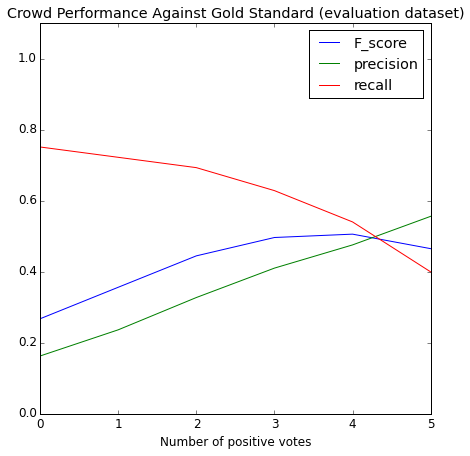

In [38]:
plot_results(official_res, "Crowd Performance Against Gold Standard (evaluation dataset)",
            "Number of positive votes", 12, (7, 7), 1)

### Performance with MeSH filtering

In [39]:
filtered_res = official_F_score("num_votes", gold_relations, final_results, apply_mesh_filter = True).sort("threshold")

In [40]:
filtered_res

,F_score,precision,recall,threshold
0,0.290285,0.182678,0.706379,0
1,0.375514,0.258682,0.684803,1
2,0.460281,0.353236,0.660413,2
3,0.509680,0.440273,0.605066,3
4,0.514049,0.504977,0.523452,4
5,0.464907,0.579021,0.388368,5


In [41]:
def pair_plot(df1, df2, title, xlabel, fontsize, figsize, linewidth, fname = None):
    matplotlib.rcParams.update({"font.size": fontsize})

    ax = df1.plot(x = "threshold", figsize = figsize,
                  title = title, ylim = (0, 1.05), linewidth = linewidth)

    ax = df2.plot(ax = ax, x = "threshold", linestyle = "--", linewidth = linewidth)
    ax.set_xlabel(xlabel)

    if fname is not None:
        plt.savefig(fname, bbox_inches = "tight")

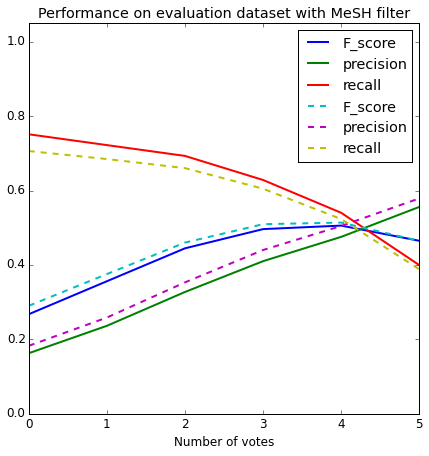

In [42]:
pair_plot(official_res, filtered_res, "Performance on evaluation dataset with MeSH filter",
          "Number of votes", 12, (7, 7), 2)